In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

In [162]:
class CentralDifference:
    def __init__(self, dt, init_disp, init_R, k, m, c):
        self.dt = dt
        self.init_disp = init_disp
        self.k = k
        self.m = m
        self.c = c
        
        self.velocity = np.zeros(init_disp.shape)
        self.accel = np.matmul(init_R, inv(self.m))
        
        self.a0 = 1 / dt ** 2
        self.a1 = 1 / 2 * dt
        self.a2 = 2 * self.a0
        self.a3 = 1 / self.a2
        
        self.em = inv(self.a0 * m + self.a1 * self.c)
        
        self._get_last(init_disp)
        
    def solve(self, U, R):
        el = R - np.matmul((self.k - self.a2 * self.m), U) - np.matmul((self.a0 * self.m - self.a1 * self.c), self.last_pos)
        nU = np.matmul(self.em, el)
        self.accel = self.a0 * (self.last_pos - 2 * U + nU)
        self.velocity = self.a1 * ((-1 * self.last_pos) + nU)
        self.last_pos = U
        return nU
    
    def _get_last(self, pos):
        self.last_pos = pos - self.dt * self.velocity + self.a3 * self.accel
        

The cell below uses the stiffness matrix from the matlab book to ensure that the formulation is correct

In [251]:
def slc(v, rows, cols):
    out = np.zeros((len(rows), len(cols)))
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            out[i, j] = v[row, col]
    return out

raw_infinitessimal_k = np.array([
     3.54627e+08, 4.20673e+06, 8.41346e+06,-2.35577e+08, 5.04808e+06, 1.00962e+07,     -168269, 3.36538e+06,           0,-1.17536e+08,-1.26202e+07, 1.68269e+06,     -673077,           0, 6.73077e+06,-1.18041e+08,      841346,-2.52404e+07, 1.17368e+08,     -841346,-1.68269e+06,           0,           0,           0,
 4.20673e+06, 1.02855e+08,      420673, 3.36538e+06,-6.73077e+07,           0, 5.04808e+06,     -588942,      504808,-1.26202e+07,-3.36118e+07,     84134.6,           0,     -673077,      336538,     -841346,-3.36959e+07,    -84134.6,      841346, 3.30228e+07,-1.26202e+06,           0,           0,           0,
 8.41346e+06,      420673, 1.04748e+08, 6.73077e+06,           0,-6.73077e+07,           0,      336538,     -168269,-1.68269e+06,    -84134.6,-3.25601e+07, 1.00962e+07,      504808,-2.35577e+06,-2.52404e+07,     84134.6,-3.47476e+07, 1.68269e+06,-1.26202e+06, 3.23918e+07,           0,           0,           0,
-2.35577e+08, 3.36538e+06, 6.73077e+06, 2.36418e+08,-8.41346e+06,-1.68269e+07,           0,           0,           0,     -168269, 5.04808e+06,           0,           0,           0,           0,     -673077,           0, 1.00962e+07,           0,           0,           0,           0,           0,           0,
 5.04808e+06,-6.73077e+07,           0,-8.41346e+06, 6.85697e+07,      841346,           0,           0,           0, 3.36538e+06,     -588942,     -336538,           0,           0,           0,           0,     -673077,     -504808,           0,           0,           0,           0,           0,           0,
 1.00962e+07,           0,-6.73077e+07,-1.68269e+07,      841346, 6.98317e+07,           0,           0,           0,           0,     -504808,     -168269,           0,           0,           0, 6.73077e+06,     -336538,-2.35577e+06,           0,           0,           0,           0,           0,           0,
     -168269, 5.04808e+06,           0,           0,           0,           0, 2.36418e+08,-8.41346e+06, 1.68269e+07,-2.35577e+08, 3.36538e+06,-6.73077e+06,           0,           0,           0,           0,           0,           0,     -673077,           0,-1.00962e+07,           0,           0,           0,
 3.36538e+06,     -588942,      336538,           0,           0,           0,-8.41346e+06, 6.85697e+07,     -841346, 5.04808e+06,-6.73077e+07,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,      504808,           0,           0,           0,
           0,      504808,     -168269,           0,           0,           0, 1.68269e+07,     -841346, 6.98317e+07,-1.00962e+07,           0,-6.73077e+07,           0,           0,           0,           0,           0,           0,-6.73077e+06,      336538,-2.35577e+06,           0,           0,           0,
-1.17536e+08,-1.26202e+07,-1.68269e+06,     -168269, 3.36538e+06,           0,-2.35577e+08, 5.04808e+06,-1.00962e+07, 3.54627e+08, 4.20673e+06,-8.41346e+06,           0,           0,           0, 1.17368e+08,     -841346, 1.68269e+06,-1.18041e+08,      841346, 2.52404e+07,     -673077,           0,-6.73077e+06,
-1.26202e+07,-3.36118e+07,    -84134.6, 5.04808e+06,     -588942,     -504808, 3.36538e+06,-6.73077e+07,           0, 4.20673e+06, 1.02855e+08,     -420673,           0,           0,           0,      841346, 3.30228e+07, 1.26202e+06,     -841346,-3.36959e+07,     84134.6,           0,     -673077,     -336538,
 1.68269e+06,     84134.6,-3.25601e+07,           0,     -336538,     -168269,-6.73077e+06,           0,-6.73077e+07,-8.41346e+06,     -420673, 1.04748e+08,           0,           0,           0,-1.68269e+06, 1.26202e+06, 3.23918e+07, 2.52404e+07,    -84134.6,-3.47476e+07,-1.00962e+07,     -504808,-2.35577e+06,
     -673077,           0, 1.00962e+07,           0,           0,           0,           0,           0,           0,           0,           0,           0, 2.36418e+08, 8.41346e+06,-1.68269e+07,-2.35577e+08,-3.36538e+06, 6.73077e+06,     -168269,-5.04808e+06,           0,           0,           0,           0,
           0,     -673077,      504808,           0,           0,           0,           0,           0,           0,           0,           0,           0, 8.41346e+06, 6.85697e+07,     -841346,-5.04808e+06,-6.73077e+07,           0,-3.36538e+06,     -588942,      336538,           0,           0,           0,
 6.73077e+06,      336538,-2.35577e+06,           0,           0,           0,           0,           0,           0,           0,           0,           0,-1.68269e+07,     -841346, 6.98317e+07, 1.00962e+07,           0,-6.73077e+07,           0,      504808,     -168269,           0,           0,           0,
-1.18041e+08,     -841346,-2.52404e+07,     -673077,           0, 6.73077e+06,           0,           0,           0, 1.17368e+08,      841346,-1.68269e+06,-2.35577e+08,-5.04808e+06, 1.00962e+07, 3.54627e+08,-4.20673e+06, 8.41346e+06,-1.17536e+08, 1.26202e+07, 1.68269e+06,     -168269,-3.36538e+06,           0,
      841346,-3.36959e+07,     84134.6,           0,     -673077,     -336538,           0,           0,           0,     -841346, 3.30228e+07, 1.26202e+06,-3.36538e+06,-6.73077e+07,           0,-4.20673e+06, 1.02855e+08,     -420673, 1.26202e+07,-3.36118e+07,    -84134.6,-5.04808e+06,     -588942,     -504808,
-2.52404e+07,    -84134.6,-3.47476e+07, 1.00962e+07,     -504808,-2.35577e+06,           0,           0,           0, 1.68269e+06, 1.26202e+06, 3.23918e+07, 6.73077e+06,           0,-6.73077e+07, 8.41346e+06,     -420673, 1.04748e+08,-1.68269e+06,     84134.6,-3.25601e+07,           0,     -336538,     -168269,
 1.17368e+08,      841346, 1.68269e+06,           0,           0,           0,     -673077,           0,-6.73077e+06,-1.18041e+08,     -841346, 2.52404e+07,     -168269,-3.36538e+06,           0,-1.17536e+08, 1.26202e+07,-1.68269e+06, 3.54627e+08,-4.20673e+06,-8.41346e+06,-2.35577e+08,-5.04808e+06,-1.00962e+07,
     -841346, 3.30228e+07,-1.26202e+06,           0,           0,           0,           0,     -673077,      336538,      841346,-3.36959e+07,    -84134.6,-5.04808e+06,     -588942,      504808, 1.26202e+07,-3.36118e+07,     84134.6,-4.20673e+06, 1.02855e+08,      420673,-3.36538e+06,-6.73077e+07,           0,
-1.68269e+06,-1.26202e+06, 3.23918e+07,           0,           0,           0,-1.00962e+07,      504808,-2.35577e+06, 2.52404e+07,     84134.6,-3.47476e+07,           0,      336538,     -168269, 1.68269e+06,    -84134.6,-3.25601e+07,-8.41346e+06,      420673, 1.04748e+08,-6.73077e+06,           0,-6.73077e+07,
           0,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,           0,-1.00962e+07,           0,           0,           0,     -168269,-5.04808e+06,           0,-2.35577e+08,-3.36538e+06,-6.73077e+06, 2.36418e+08, 8.41346e+06, 1.68269e+07,
           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,     -504808,           0,           0,           0,-3.36538e+06,     -588942,     -336538,-5.04808e+06,-6.73077e+07,           0, 8.41346e+06, 6.85697e+07,      841346,
           0,           0,           0,           0,           0,           0,           0,           0,           0,-6.73077e+06,     -336538,-2.35577e+06,           0,           0,           0,           0,     -504808,     -168269,-1.00962e+07,           0,-6.73077e+07, 1.68269e+07,      841346, 6.98317e+07,

])
global_stiffness = raw_infinitessimal_k.reshape(24, 24)
indices = [i for i in range(6, 12)] + [i for i in range(18, 24)]


np.set_printoptions(precision=2, suppress=True)
K = slc(global_stiffness, indices, indices)
print(K/1e8)

[[ 2.36 -0.08  0.17 -2.36  0.03 -0.07 -0.01  0.   -0.1   0.    0.    0.  ]
 [-0.08  0.69 -0.01  0.05 -0.67  0.    0.   -0.01  0.01  0.    0.    0.  ]
 [ 0.17 -0.01  0.7  -0.1   0.   -0.67 -0.07  0.   -0.02  0.    0.    0.  ]
 [-2.36  0.05 -0.1   3.55  0.04 -0.08 -1.18  0.01  0.25 -0.01  0.   -0.07]
 [ 0.03 -0.67  0.    0.04  1.03 -0.   -0.01 -0.34  0.    0.   -0.01 -0.  ]
 [-0.07  0.   -0.67 -0.08 -0.    1.05  0.25 -0.   -0.35 -0.1  -0.01 -0.02]
 [-0.01  0.   -0.07 -1.18 -0.01  0.25  3.55 -0.04 -0.08 -2.36 -0.05 -0.1 ]
 [ 0.   -0.01  0.    0.01 -0.34 -0.   -0.04  1.03  0.   -0.03 -0.67  0.  ]
 [-0.1   0.01 -0.02  0.25  0.   -0.35 -0.08  0.    1.05 -0.07  0.   -0.67]
 [ 0.    0.    0.   -0.01  0.   -0.1  -2.36 -0.03 -0.07  2.36  0.08  0.17]
 [ 0.    0.    0.    0.   -0.01 -0.01 -0.05 -0.67  0.    0.08  0.69  0.01]
 [ 0.    0.    0.   -0.07 -0.   -0.02 -0.1   0.   -0.67  0.17  0.01  0.7 ]]


In [266]:
small_poissons_k = np.array([[16887,200.32,400.641,-11217.9,240.385,480.769,-8.01282,160.256,0,-5596.95,-600.961,80.1282,-32.0513,0,320.513,-5620.99,40.0641,-1201.92,5588.94,-40.0641,-80.1282,0,0,0],
[200.32,4897.84,20.0321,160.256,-3205.13,0,240.385,-28.0449,24.0385,-600.961,-1600.56,4.00641,0,-32.0513,16.0256,-40.0641,-1604.57,-4.00641,40.0641,1572.52,-60.0962,0,0,0],
[400.641,20.0321,4987.98,320.513,0,-3205.13,0,16.0256,-8.01282,-80.1282,-4.00641,-1550.48,480.769,24.0385,-112.179,-1201.92,4.00641,-1654.65,80.1282,-60.0962,1542.47,0,0,0],
[-11217.9,160.256,320.513,11258,-400.641,-801.282,0,0,0,-8.01282,240.385,0,0,0,0,-32.0513,0,480.769,0,0,0,0,0,0],
[240.385,-3205.13,0,-400.641,3265.22,40.0641,0,0,0,160.256,-28.0449,-16.0256,0,0,0,0,-32.0513,-24.0385,0,0,0,0,0,0],
[480.769,0,-3205.13,-801.282,40.0641,3325.32,0,0,0,0,-24.0385,-8.01282,0,0,0,320.513,-16.0256,-112.179,0,0,0,0,0,0],
[-8.01282,240.385,0,0,0,0,11258,-400.641,801.282,-11217.9,160.256,-320.513,0,0,0,0,0,0,-32.0513,0,-480.769,0,0,0],
[160.256,-28.0449,16.0256,0,0,0,-400.641,3265.22,-40.0641,240.385,-3205.13,0,0,0,0,0,0,0,0,-32.0513,24.0385,0,0,0],
[0,24.0385,-8.01282,0,0,0,801.282,-40.0641,3325.32,-480.769,0,-3205.13,0,0,0,0,0,0,-320.513,16.0256,-112.179,0,0,0],
[-5596.95,-600.961,-80.1282,-8.01282,160.256,0,-11217.9,240.385,-480.769,16887,200.32,-400.641,0,0,0,5588.94,-40.0641,80.1282,-5620.99,40.0641,1201.92,-32.0513,0,-320.513],
[-600.961,-1600.56,-4.00641,240.385,-28.0449,-24.0385,160.256,-3205.13,0,200.32,4897.84,-20.0321,0,0,0,40.0641,1572.52,60.0962,-40.0641,-1604.57,4.00641,0,-32.0513,-16.0256],
[80.1282,4.00641,-1550.48,0,-16.0256,-8.01282,-320.513,0,-3205.13,-400.641,-20.0321,4987.98,0,0,0,-80.1282,60.0962,1542.47,1201.92,-4.00641,-1654.65,-480.769,-24.0385,-112.179],
[-32.0513,0,480.769,0,0,0,0,0,0,0,0,0,11258,400.641,-801.282,-11217.9,-160.256,320.513,-8.01282,-240.385,0,0,0,0],
[0,-32.0513,24.0385,0,0,0,0,0,0,0,0,0,400.641,3265.22,-40.0641,-240.385,-3205.13,0,-160.256,-28.0449,16.0256,0,0,0],
[320.513,16.0256,-112.179,0,0,0,0,0,0,0,0,0,-801.282,-40.0641,3325.32,480.769,0,-3205.13,0,24.0385,-8.01282,0,0,0],
[-5620.99,-40.0641,-1201.92,-32.0513,0,320.513,0,0,0,5588.94,40.0641,-80.1282,-11217.9,-240.385,480.769,16887,-200.32,400.641,-5596.95,600.961,80.1282,-8.01282,-160.256,0],
[40.0641,-1604.57,4.00641,0,-32.0513,-16.0256,0,0,0,-40.0641,1572.52,60.0962,-160.256,-3205.13,0,-200.32,4897.84,-20.0321,600.961,-1600.56,-4.00641,-240.385,-28.0449,-24.0385],
[-1201.92,-4.00641,-1654.65,480.769,-24.0385,-112.179,0,0,0,80.1282,60.0962,1542.47,320.513,0,-3205.13,400.641,-20.0321,4987.98,-80.1282,4.00641,-1550.48,0,-16.0256,-8.01282],
[5588.94,40.0641,80.1282,0,0,0,-32.0513,0,-320.513,-5620.99,-40.0641,1201.92,-8.01282,-160.256,0,-5596.95,600.961,-80.1282,16887,-200.32,-400.641,-11217.9,-240.385,-480.769],
[-40.0641,1572.52,-60.0962,0,0,0,0,-32.0513,16.0256,40.0641,-1604.57,-4.00641,-240.385,-28.0449,24.0385,600.961,-1600.56,4.00641,-200.32,4897.84,20.0321,-160.256,-3205.13,0],
[-80.1282,-60.0962,1542.47,0,0,0,-480.769,24.0385,-112.179,1201.92,4.00641,-1654.65,0,16.0256,-8.01282,80.1282,-4.00641,-1550.48,-400.641,20.0321,4987.98,-320.513,0,-3205.13],
[0,0,0,0,0,0,0,0,0,-32.0513,0,-480.769,0,0,0,-8.01282,-240.385,0,-11217.9,-160.256,-320.513,11258,400.641,801.282],
[0,0,0,0,0,0,0,0,0,0,-32.0513,-24.0385,0,0,0,-160.256,-28.0449,-16.0256,-240.385,-3205.13,0,400.641,3265.22,40.0641],
[0,0,0,0,0,0,0,0,0,-320.513,-16.0256,-112.179,0,0,0,0,-24.0385,-8.01282,-480.769,0,-3205.13,801.282,40.0641,3325.32]])

small_poissons_k
indices = [i for i in range(6, 12)] + [i for i in range(18, 24)]
K = slc(small_poissons_k, indices, indices)
K

array([[ 11258.  ,   -400.64,    801.28, -11217.9 ,    160.26,   -320.51,
           -32.05,      0.  ,   -480.77,      0.  ,      0.  ,      0.  ],
       [  -400.64,   3265.22,    -40.06,    240.38,  -3205.13,      0.  ,
             0.  ,    -32.05,     24.04,      0.  ,      0.  ,      0.  ],
       [   801.28,    -40.06,   3325.32,   -480.77,      0.  ,  -3205.13,
          -320.51,     16.03,   -112.18,      0.  ,      0.  ,      0.  ],
       [-11217.9 ,    240.38,   -480.77,  16887.  ,    200.32,   -400.64,
         -5620.99,     40.06,   1201.92,    -32.05,      0.  ,   -320.51],
       [   160.26,  -3205.13,      0.  ,    200.32,   4897.84,    -20.03,
           -40.06,  -1604.57,      4.01,      0.  ,    -32.05,    -16.03],
       [  -320.51,      0.  ,  -3205.13,   -400.64,    -20.03,   4987.98,
          1201.92,     -4.01,  -1654.65,   -480.77,    -24.04,   -112.18],
       [   -32.05,      0.  ,   -320.51,  -5620.99,    -40.06,   1201.92,
         16887.  ,   -200.32,   

### Some Debugging...
Currently, my code seems to grow without bound when I run the solver despite the system reaching equilibrium in the basic test below:

[0.   0.39]
[0.03 1.45]
[0.17 2.83]
[0.49 4.14]
[1.02 5.02]
[1.7  5.26]
[2.4 4.9]
[2.91 4.17]
[3.07 3.37]
[2.77 2.78]
[2.04 2.54]
[1.02 2.6 ]


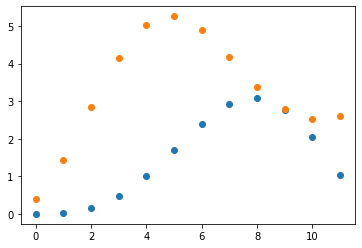

In [252]:
init_disp = np.array([0, 0])
init_R = np.array([0, 10])
k = np.array([[6, -2], [-2, 4]])
m = np.array([[2, 0], [0, 1]])
# To show damping, uncomment this.
# c = np.array([[100, 0], [0, 100]])
c = np.array([[0, 0], [0, 0]])
cd = CentralDifference(0.28, init_disp, init_R, k, m, c)

U = np.array([0, 0])
R = np.array([0, 10])
results = []
n = 12
for i in range(n):
    U = cd.solve(U, R)
    print(U)
    results.append(U)
    
x = [i for i in range(n)]
    
results = np.array(results)
plt.scatter(x, results[:, 0])
plt.scatter(x, results[:, 1])
plt.show()

### Now
I intend to roll together the linear solver and put the book tetrahedrals from Matlab finite elements and see if we get a similar wavy result.

In [277]:
U = np.zeros(12)
R = np.array([
    0,
3.125,
    0,
    0,
 6.25,
    0,
    0,
 6.25,
    0,
    0,
3.125,
    0,
])
m = np.identity(12)
c = np.identity(12)
cd = CentralDifference(1e-7, U, R, K, m, c)

results = []
n = 30
for i in range(n):
    results.append(U)
    U = cd.solve(U, R)

### Results
This experiment shows that the values explode without bound, never reaching oscillation. Also, the boundary conditions applied within the force vector seem to not be respected, instead, all the values explode and move after a certain point. This was also observed in the C++ sim.

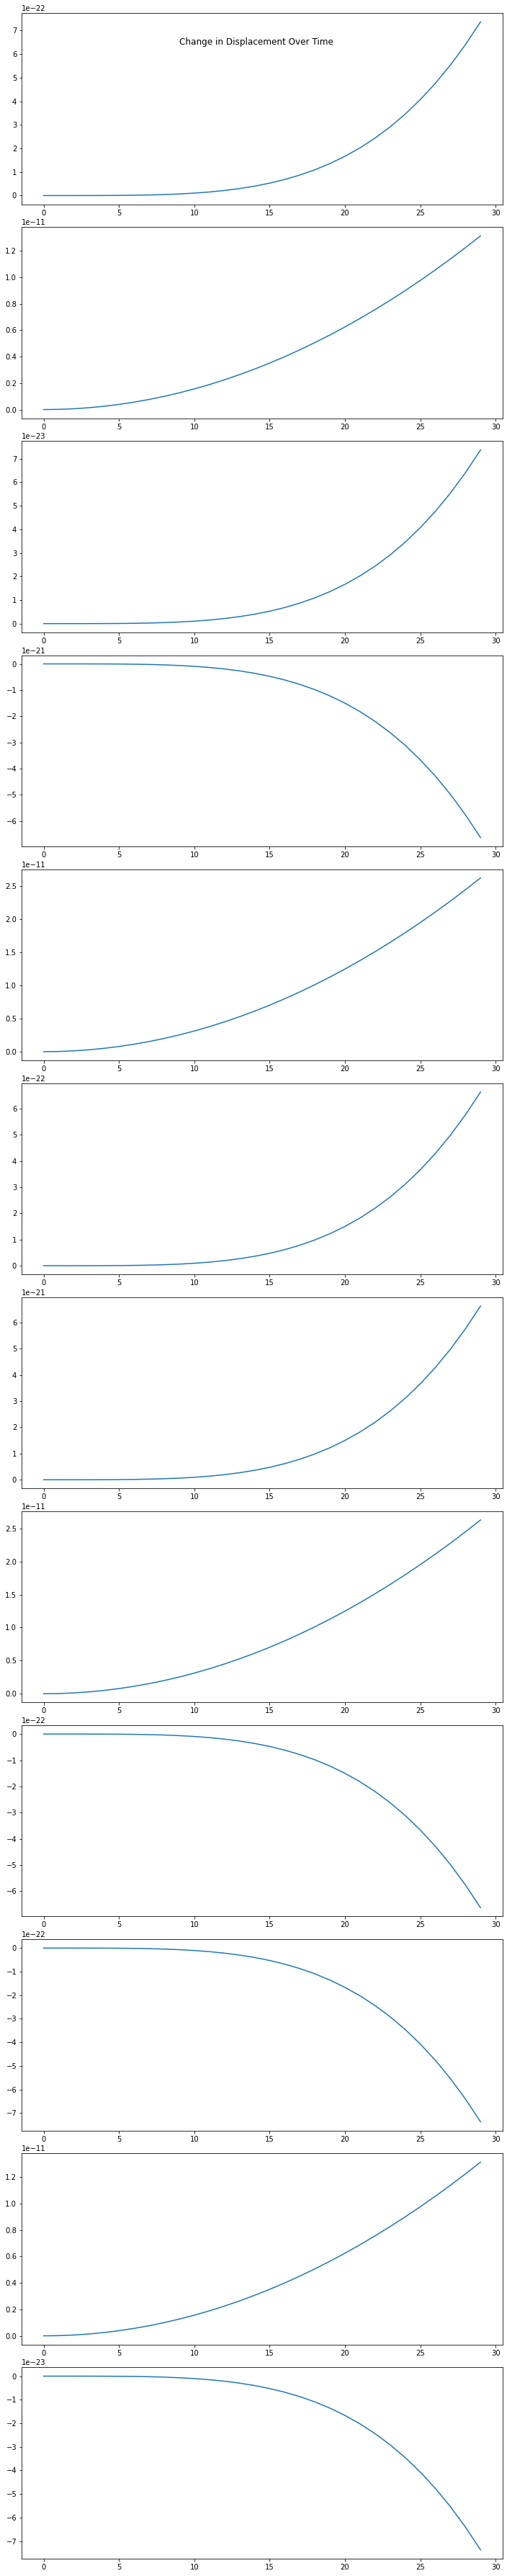

In [278]:
x = [i for i in range(n)]
    
results = np.array(results)
fig, axs = plt.subplots(U.shape[0], figsize=(10,50))
fig.suptitle('Change in Displacement Over Time')
fig.tight_layout()
for i, ax in enumerate(axs):
    ax.plot(x, results[:, i])
plt.show()